#### Import required libraries

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import json
import hourglass 
import preprocessing
import utils

#### Visualize charts and annotations

In [2]:
# File paths to load JSON files
train_file = 'DeepRuleDataset/bardata(1031)/bar/annotations/temp/train_annotations_processed.json'
val_file = 'DeepRuleDataset/bardata(1031)/bar/annotations/temp/val_annotations_processed.json'

# Load processed annotations files
with open(train_file) as f:
        train_annotations = json.load(f)
with open(val_file) as f:
        val_annotations = json.load(f)

In [3]:
train_images = train_annotations['images']
train_annotations = train_annotations['annotations']
val_images = val_annotations['images']
val_annotations = val_annotations['annotations']

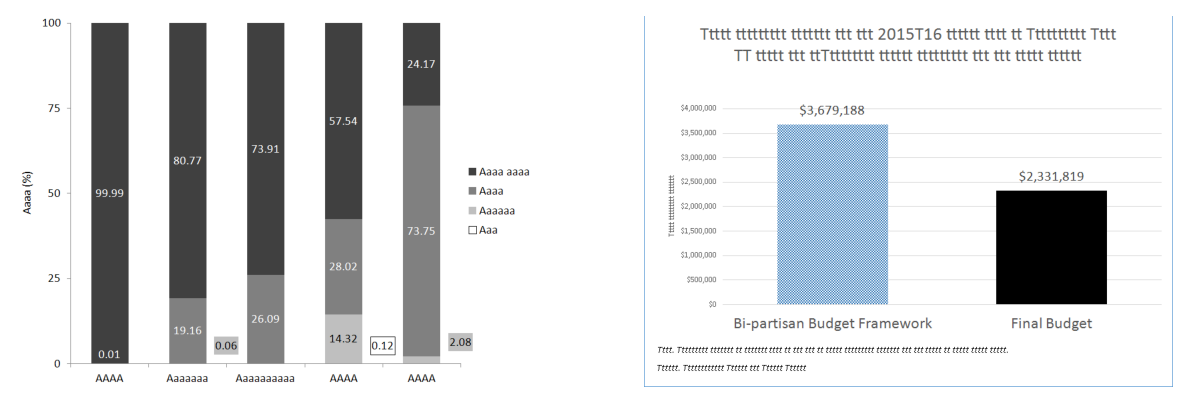

In [4]:
# Display images and annotations from training and validation data
TRAIN_PATH_BAR = 'DeepRuleDataset/bardata(1031)/bar/images/train2019'
VAL_PATH_BAR = 'DeepRuleDataset/bardata(1031)/bar/images/val2019'

index = 0
file_name = train_images[index]['file_name']
train_path = os.path.join(TRAIN_PATH_BAR, file_name)
train_image = cv2.cvtColor(cv2.imread(train_path), cv2.COLOR_BGR2RGB)
index_ = 750
file_name = val_images[index_]['file_name']
val_path = os.path.join(VAL_PATH_BAR, file_name)
val_image = cv2.cvtColor(cv2.imread(val_path), cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(train_image)
axs[1].imshow(val_image)
axs[0].axis('off')
axs[1].axis('off')
plt.show()

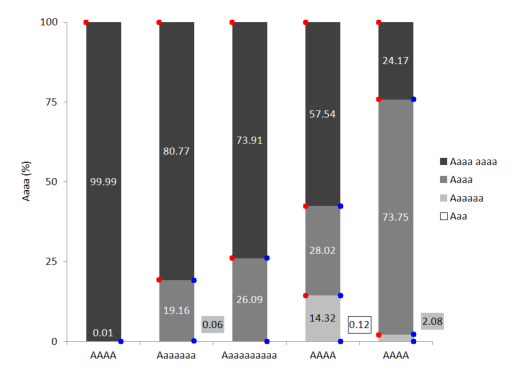

In [5]:
annotation = list(map(lambda x: x['bbox'], train_annotations[index]))
utils.annotshow(train_image, annotation)

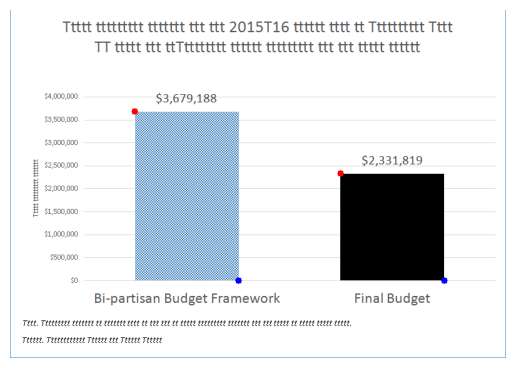

In [6]:
annotation_ = list(map(lambda x: x['bbox'], val_annotations[index_]))
utils.annotshow(val_image, annotation_)

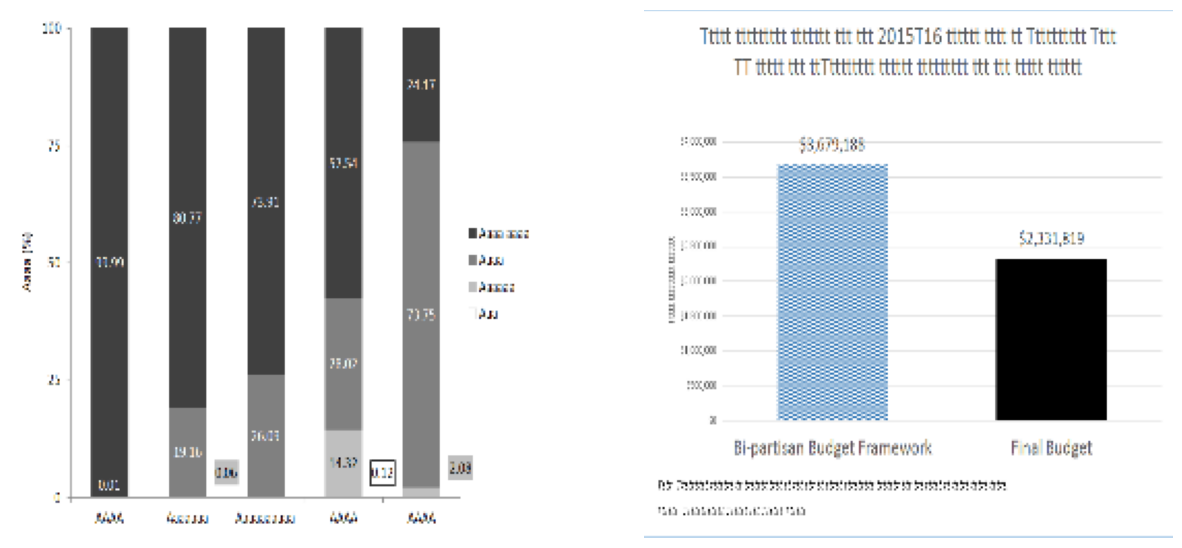

In [7]:
# Display resized images and scaled annotations
train_image_resized = cv2.resize(train_image, (256, 256))
val_image_resized = cv2.resize(val_image, (256, 256))
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(train_image_resized)
axs[1].imshow(val_image_resized)
axs[0].axis('off')
axs[1].axis('off')
plt.show()

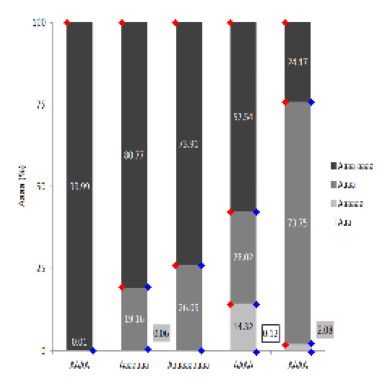

In [8]:
train_image_shape = (train_images[index]['width'], train_images[index]['height'])
OUTPUT_SHAPE = (256, 256)
scaled_train_annotation = preprocessing.scale(train_annotations[index], train_image_shape, OUTPUT_SHAPE)
utils.annotshow(train_image_resized, list(map(lambda x: x['bbox'], scaled_train_annotation)), radius=2)

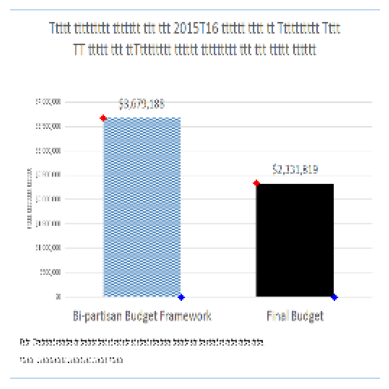

In [9]:
val_image_shape = (val_images[index_]['width'], val_images[index_]['height'])
scaled_val_annotation = preprocessing.scale(val_annotations[index_], val_image_shape, OUTPUT_SHAPE)
utils.annotshow(val_image_resized, list(map(lambda x: x['bbox'], scaled_val_annotation)), radius=2)

#### Preprocessing

In [10]:
TRAIN_HEATMAPS_PATH = 'DeepRuleDataset/bardata(1031)/bar/heatmaps/train'

In [18]:
# Scale image annotations according to OUTPUT_SHAPE
# Contruct bottom right annotation
train_set_length = len(train_images)
train_annotations_transformed = []
for i in range(train_set_length):
    img_shape = (train_images[i]['width'], train_images[i]['height'])
    train_annotations_transformed.append(preprocessing.transform(train_annotations[i], img_shape, OUTPUT_SHAPE))

# Generate batches of heatmaps beforehand
# Run this code once to generate heatmaps and save them to disk
label_gen = preprocessing.label_generator(train_annotations_transformed, batch_size=32)
utils.delete_contents(TRAIN_HEATMAPS_PATH)

for i, tensor in enumerate(label_gen):
    file_name = f'batch_{i+1}'
    np.savez_compressed(os.path.join(TRAIN_HEATMAPS_PATH, file_name), batch=tensor.numpy())
    print(f'{file_name} saved')

Deleting the contents in the DeepRuleDataset/bardata(1031)/bar/heatmaps/train
batch_1 saved
batch_2 saved
batch_3 saved
batch_4 saved
batch_5 saved
batch_6 saved
batch_7 saved
batch_8 saved
batch_9 saved
batch_10 saved
batch_11 saved
batch_12 saved
batch_13 saved
batch_14 saved
batch_15 saved
batch_16 saved
batch_17 saved
batch_18 saved
batch_19 saved
batch_20 saved
batch_21 saved
batch_22 saved
batch_23 saved
batch_24 saved
batch_25 saved
batch_26 saved
batch_27 saved
batch_28 saved
batch_29 saved
batch_30 saved
batch_31 saved
batch_32 saved
batch_33 saved
batch_34 saved
batch_35 saved
batch_36 saved
batch_37 saved
batch_38 saved
batch_39 saved
batch_40 saved
batch_41 saved
batch_42 saved
batch_43 saved
batch_44 saved
batch_45 saved
batch_46 saved
batch_47 saved
batch_48 saved
batch_49 saved
batch_50 saved
batch_51 saved
batch_52 saved
batch_53 saved
batch_54 saved
batch_55 saved
batch_56 saved
batch_57 saved
batch_58 saved
batch_59 saved
batch_60 saved
batch_61 saved
batch_62 saved
b

KeyboardInterrupt: 

In [12]:
heatmaps = sorted(glob(pathname='*.npz', root_dir=TRAIN_HEATMAPS_PATH))
train_heatmaps = [os.path.join(TRAIN_HEATMAPS_PATH, item) for item in heatmaps]
gen = preprocessing.generator(train_images, train_heatmaps, batch_size=32, output_shape=OUTPUT_SHAPE, file_path=TRAIN_PATH_BAR)

#### Preprocessing Validation Data

In [13]:
VAL_HEATMAPS_PATH = 'DeepRuleDataset/bardata(1031)/bar/heatmaps/val'

In [14]:
val_set_length = len(val_images)
val_annotations_transformed = []
for i in range(val_set_length):
    img_shape = (val_images[i]['width'], val_images[i]['height'])
    val_annotations_transformed.append(preprocessing.transform(val_annotations[i], img_shape, OUTPUT_SHAPE))

val_label_gen = preprocessing.label_generator(val_annotations_transformed, batch_size=32)
utils.delete_contents(VAL_HEATMAPS_PATH)

for i, tensor in enumerate(val_label_gen):
    file_name = f'batch_{i+1}'
    np.savez_compressed(os.path.join(VAL_HEATMAPS_PATH, file_name), batch=tensor.numpy())
    print(f'{file_name} saved')

Deleting the contents in the DeepRuleDataset/bardata(1031)/bar/heatmaps/val
batch_1 saved


In [15]:
val_heatmaps = sorted(glob(pathname='*.npz', root_dir=VAL_HEATMAPS_PATH))
val_heatmaps = [os.path.join(VAL_HEATMAPS_PATH, item) for item in val_heatmaps]
val_gen = preprocessing.generator(val_images, val_heatmaps, batch_size=32, output_shape=OUTPUT_SHAPE, file_path=VAL_PATH_BAR)

#### Training

In [16]:
# Define custom loss function
def custom_loss(y_true, y_pred):
    loss = tf.math.reduce_mean(tf.math.square(y_pred - y_true))
    return loss

In [17]:
from hourglass import StackedHourglassNetwork
from keras.metrics import RootMeanSquaredError
from keras.callbacks import ModelCheckpoint

stacked_hourglass = StackedHourglassNetwork(input_shape=(256, 256, 3), num_stack=1)
stacked_hourglass.compile(optimizer='sgd', loss=custom_loss, metrics=[RootMeanSquaredError()])
checkpoint_cb = ModelCheckpoint('SavedModels/key-point-detector.keras')
history = stacked_hourglass.fit(x=gen, validation_data=val_gen, epochs=30, callbacks=[checkpoint_cb])

Epoch 1/30
      1/Unknown 229s 229s/step - loss: 1.3102 - root_mean_squared_error: 1.1446

2024-04-14 19:46:51.619939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.10/3.10.13/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-14 19:47:13.516544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 252s 252s/step - loss: 0.9826 - root_mean_squared_error: 1.1446 - val_loss: 2653.5701 - val_root_mean_squared_error: 72.8501
Epoch 2/30


2024-04-14 19:47:13.949680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:13.963925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 3/30


2024-04-14 19:47:14.173515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:14.187980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 4/30


2024-04-14 19:47:14.392160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:14.406794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 5/30


2024-04-14 19:47:14.610394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:14.624249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 6/30


2024-04-14 19:47:14.833518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:14.847184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 7/30


2024-04-14 19:47:15.051802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:15.065611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 8/30


2024-04-14 19:47:15.269448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:15.282917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 9/30


2024-04-14 19:47:15.486700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:15.500514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 10/30


2024-04-14 19:47:15.701110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:15.714891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 11/30


2024-04-14 19:47:15.923761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:15.937724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 12/30


2024-04-14 19:47:16.141076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:16.154806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 13/30


2024-04-14 19:47:16.355777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:16.369406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 14/30


2024-04-14 19:47:16.570946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:16.584831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 15/30


2024-04-14 19:47:16.790265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:16.804232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 16/30


2024-04-14 19:47:17.006110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:17.019878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 17/30


2024-04-14 19:47:17.225593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:17.239510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 18/30


2024-04-14 19:47:17.441121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:17.455690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 19/30


2024-04-14 19:47:17.663313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:17.677087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 20/30


2024-04-14 19:47:17.881960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:17.896440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 21/30


2024-04-14 19:47:18.099098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:18.112665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 22/30


2024-04-14 19:47:18.315406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:18.328917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00


2024-04-14 19:47:18.534387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:18.547831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 24/30


2024-04-14 19:47:18.750299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:18.764261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 25/30


2024-04-14 19:47:18.968143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:18.981748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 26/30


2024-04-14 19:47:19.185383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:19.199051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 27/30


2024-04-14 19:47:19.405967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:19.419661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 28/30


2024-04-14 19:47:19.622487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:19.636263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 29/30


2024-04-14 19:47:19.839474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:19.853518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 30/30


2024-04-14 19:47:20.057793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-14 19:47:20.071358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00


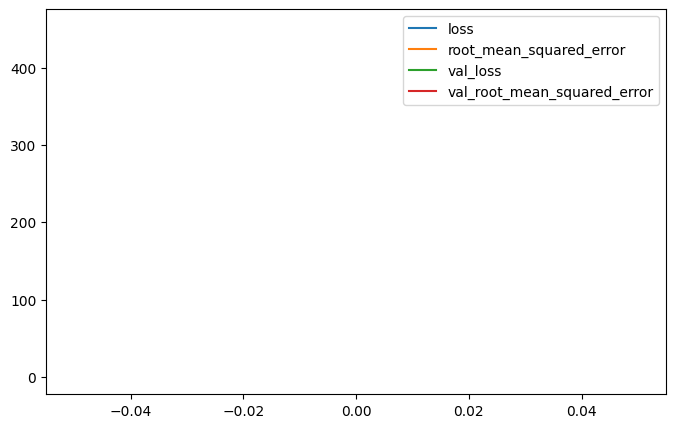

In [25]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [16]:
stacked_hourglass.summary()

Model: "stacked_hourglass"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ re_lu[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,160 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      8,320 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │      8,320 │ re_lu_3[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ conv2d_1[0][0],   │
│                     │ 128)              │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ add[0][0]         │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat

 Total params: 4,301,700 (16.41 MB)

 Trainable params: 4,280,962 (16.33 MB)

 Non-trainable params: 20,736 (81.00 KB)

 Optimizer params: 2 (12.00 B)

#### Inference

In [21]:
import tensorflow as tf

# Create a tensor of shape (256, 256, 2) with dtype=tf.float32
tensor = tf.zeros(shape=(32, 256, 256, 2), dtype=tf.float32)

# Display information about the tensor
print("Tensor shape:", tensor.shape)
print("Data type:", tensor.dtype)


Tensor shape: (32, 256, 256, 2)
Data type: <dtype: 'float32'>


In [36]:
np.savez_compressed("tensor.npz", batch=tensor)

In [42]:
np.load("tensor.npz")

NpzFile 'tensor.npz' with keys: batch